# **01 Visualise phase assemblages**
---

This notebook shows you how to:
1. Call theriak from python with pytheriak.
2. Retrieve system parameters, mineral modes, and mineral compositions from the pytheriak.Rock-object.
3. Visualise petrological data with python.🐍

This notebook is tutorial to introduce you to the basic functionality of the pytheriak package.

**Requirements:**
- python >= 3.10
*with the following packages installed:*
- pytheriak
- matplotlib
- seaborn
- pandas

*Theriak-Domino back-end:*
- A working Theriak-Domino installation.
- theriak.ini file in the working directory.
- Thermodynamic databases to use with Theriak in the working directory.
---
*Check-out the [Theriak-Domino github repository](https://github.com/Theriak-Domino/theriak-domino) for more information on how to set-up Theriak-Domino.*

### Import all required libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pytheriak import wrapper

### Initiate a TherCaller-object.
The argument `programs_dir` must be set to the directory of your Theriak-Domino installation.\
The `database`-file (`"td-ds62-mp50-v05.txt"`) must be in your working directory, alongside this jupyter notebook. Get the database from [Databases](https://github.com/Theriak-Domino/Databases) on github.\
The Theriak-Domino database `"td-ds62-mp50-v05.txt"` is based on the Holland and Powell (2011, https://doi.org/10.1111/j.1525-1314.2010.00923.x) updated thermodynamic dataset file with accompanying solution models for pelites.

In [2]:
theriak = wrapper.TherCaller(programs_dir="C:\\TheriakDominoWIN\\Programs",
                             database="td-ds62-mp50-v05.txt",
                             theriak_version="v2023.03.06")

Define a pressure and temperature of interest.\
The bulk rock used here is worldwide median metapelite from Forshaw and Pattison (2023, https://doi.org/10.1130/G50542.1).\
Water is assumed to be in excess and set as `"H(10)"`.\
A small amount of excess oxygen `"O(0.01)"` has been added to the bulk composition to allow a minor amount of ferric-bearing members to be stable (see https://www.dtinkham.net/peq.html for explanation).

In [3]:
pressure = 5000
temperature = 580
bulk = "SI(22.84)TI(0.24)AL(7.78)FE(2.04)MN(0.02)MG(1.28)CA(0.25)NA(0.95)K(1.79)H(10)O(?)O(0.01)"

Call theriak for the *G*-minimisation at the *P* and *T* of interest.

In [4]:
rock, element_list = theriak.minimisation(pressure, temperature, bulk)

### Examine output.

`element_list` is a list containing all element names (`str`) present in the modelled bulk rock.\
The index of an element name in this list is a global valid index for all list holding compositional data (mineral-, fluid- and bulk-composition).

In [5]:
print(element_list)
# get the index of an element of interest
idx_CA = element_list.index("CA")
print(idx_CA)

['O', 'SI', 'TI', 'AL', 'FE', 'MG', 'MN', 'CA', 'NA', 'K', 'H']
7


`rock` is a `pytheriak.Rock`-object encapsulating all the state properties of the system at minimal *G*.

In [6]:
print(type(rock))
# use the dir method to check out the objects attributes
dir(rock)

<class 'pytheriak.wrapper.Rock'>


['bulk_composition_mol_percent',
 'bulk_composition_moles',
 'fluid_assemblage',
 'g_system',
 'g_system_per_mol_of_input',
 'mineral_assemblage',
 'mineral_delta_G',
 'pressure',
 'temperature',
 'therin_PT',
 'therin_bulk']

Access bulk properties such as `g_system`, `bulk_composition_mol_percent`, ...

In [7]:
rock.g_system   # in Joule

-33616714.95

Or return the `mineral_assemblage` or `fluid_assemblage`. These lists hold `pytheriak.Phase`-objects with their respective properties.

In [8]:
rock.mineral_assemblage
# return the first mineral in the list and show its name
rock.mineral_assemblage[0].name

'FSP4TR_ab'

Properties of `pytheriak.Phase`-objects are most efficiently accessed by list comprehensions.\
This is a very pythonic way to loop over lists in an efficient and easily readable manner.

In [9]:
mineral_names = [mineral.name for mineral in rock.mineral_assemblage]
mineral_modes = [mineral.vol_percent for mineral in rock.mineral_assemblage]

print(mineral_names)
print(mineral_modes)

['FSP4TR_ab', 'WM_mu', 'BI14_annm', 'ST14_fst', 'ILM00_oilm1', 'q']
[12.8524, 19.0816, 19.7347, 6.5059, 0.732, 41.0935]


Phase composition is a list (representing a compositional vector) with the ordering as defined in the `element_list`. Return the composition of biotite using the following:

In [10]:
mineral_composition_apfu = [mineral.composition_apfu for mineral in rock.mineral_assemblage]
print(element_list)
print(mineral_composition_apfu[2])

['O', 'SI', 'TI', 'AL', 'FE', 'MG', 'MN', 'CA', 'NA', 'K', 'H']
[12.0, 2.628991, 0.077487, 1.604766, 1.489676, 1.1889, 0.01018, 0.0, 0.0, 1.0, 1.845027]


### **Plotting I:** Phase assemblage

Use `matplotlib` to set up a figure and plot a pie chart of the mineral modes with `ax.pie()`.\
`seaborn` is used to access built-in colour palettes.

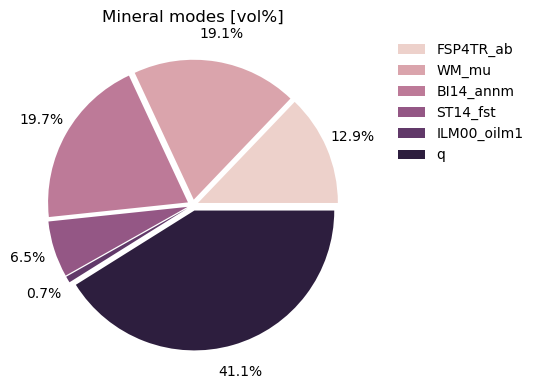

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))

colors = sns.cubehelix_palette(len(mineral_modes))
explode = np.repeat(0.04, len(mineral_modes))

ax.pie(mineral_modes,
       autopct="%.1f%%",
       pctdistance=1.2,
       colors=colors,
       explode=explode)

ax.set_aspect("equal")

ax.legend(labels=mineral_names, bbox_to_anchor=(1.05, 1), frameon=False)

ax.set_title("Mineral modes [vol%]")

fig.tight_layout()
plt.show()

### **Plotting II:** Element distribution between phases

Access the mineral and bulk rock composition in moles and convert them into arrays.

In [12]:
mineral_composition = np.array([mineral.composition_moles for mineral in rock.mineral_assemblage])
bulk_composition = np.array(rock.bulk_composition_moles)

print(mineral_composition.shape)
print(bulk_composition.shape)


(6, 11)
(11,)


`mineral_composition` is a 6 x 11-matrix, holding the compositional vector (11 elements) of the six stable minerals.\
`bulk_composition` is the compositional vector of the bulk rock.\
Dividing the `mineral_composition`-matrix elementwise with `bulk_composition`-vector results in a 6 x 11-matrix of relative element contribution.

In [13]:
mineral_composition_rel = mineral_composition / bulk_composition

Access the values for iron, magnesium, and manganese for all minerals.\
For iron $\text{Fe}_{\text{tot}}$ is plotted. With the chosen small amount of excess oxygen `"O(0.1)"`, $\text{Fe}_{\text{tot}} \approx \text{Fe}^{2+}$.

In [14]:
fe = mineral_composition_rel.T[element_list.index("FE")]
mg = mineral_composition_rel.T[element_list.index("MG")]
mn = mineral_composition_rel.T[element_list.index("MN")]

Use `seaborn`'s `sns.barplot()` to plot relative distribution of these elements between the stable minerals.

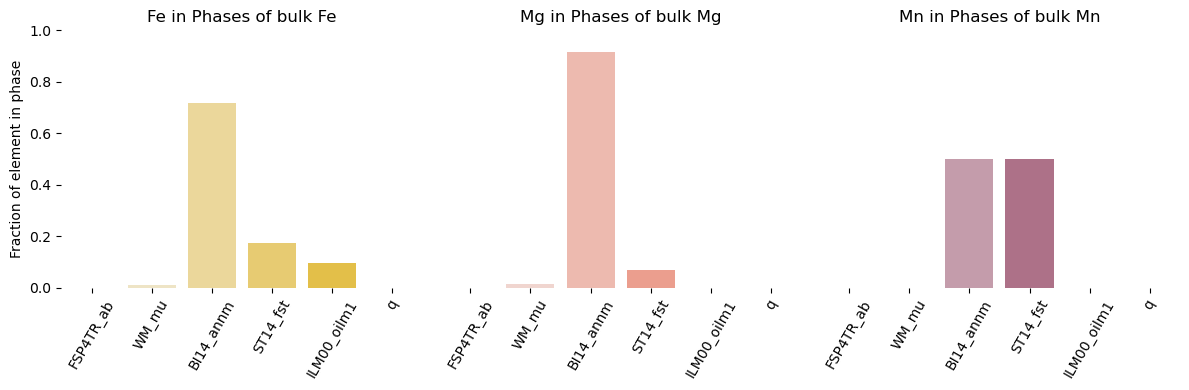

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# plot Fe-distribution
axs[0].tick_params(axis='x', rotation=60)
axs[0].set_frame_on(False)
axs[0].set_ylim(0, 1)
axs[0].set_ylabel("Fraction of element in phase")
axs[0].set_title("Fe in Phases of bulk Fe")
sns.barplot(x=mineral_names, y=fe, ax=axs[0], palette=sns.color_palette("light:#FFC300"))
# plot Mg-distribution
axs[1].tick_params(axis='x', rotation=60)
axs[1].set_frame_on(False)
axs[1].set_ylim(0, 1)
axs[1].axes.get_yaxis().set_visible(False)
axs[1].set_title("Mg in Phases of bulk Mg")
sns.barplot(x=mineral_names, y=mg, ax=axs[1], palette=sns.color_palette("light:#FF5733"))
# plot Mn-distribution
axs[2].tick_params(axis='x', rotation=60)
axs[2].set_frame_on(False)
axs[2].set_ylim(0, 1)
axs[2].axes.get_yaxis().set_visible(False)
axs[2].set_title("Mn in Phases of bulk Mn")
sns.barplot(x=mineral_names, y=mn, ax=axs[2], palette=sns.color_palette("light:#900C3F"))

fig.tight_layout()
plt.show()